Data is food for AI. In one of the [talks](https://www.youtube.com/watch?v=Yqj7Kyjznh4), Prof Andrew Ng explains the first principle of data-centric AI, i.e.,  "make y labels consistent". He takes the example of a classification task wherein defective pills are separated from the good ones on the basis of scratch lengths. In this notebook, we show the application of the same concept for anomaly detection in a time series. We select a representative time series of memory utilization to discuss how and why a data-centric approach can outperform a plain model-centric approach. 

### 1. Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\guptasu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\guptasu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\guptasu\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\guptasu\AppData\Loc

### 2. Read the data

There are three columns in the data. The first column contains time indices. The second contains value of time series. Third column consists of labels. If the label is 0, then the value is normal else an anomaly. 

In [2]:
df1 = pd.read_csv("D:\Python\ML\ML web\VuNet Data Centrik AI\Ex2a.csv"); ### Ensure that the CSV file path is correct here

t = df1['time'].to_numpy();t=t.reshape(np.size(t),1);
y = df1['value'].to_numpy();y=y.reshape(np.size(y),1);
labels = df1['is_anom'].to_numpy();labels=labels.reshape(np.size(labels),1);
anom_ind=np.nonzero(labels)[0]

### 3. Plot the time series without anomaly labels

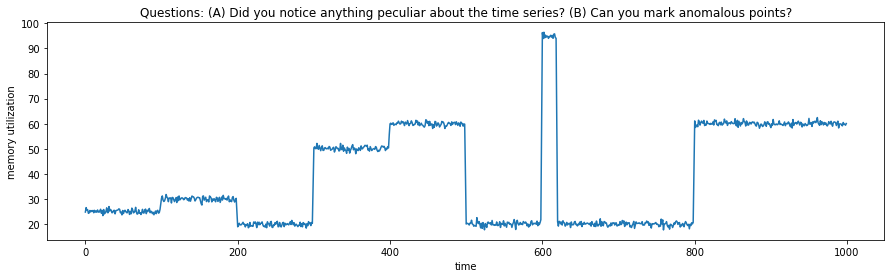

In [3]:
plt.figure(figsize=(15,4))
plt.plot(t,y);
plt.xlabel('time')
plt.ylabel('memory utilization')
plt.title('Questions: (A) Did you notice anything peculiar about the time series? (B) Can you mark anomalous points?');
plt.show()

### 4. Add anomaly labels 

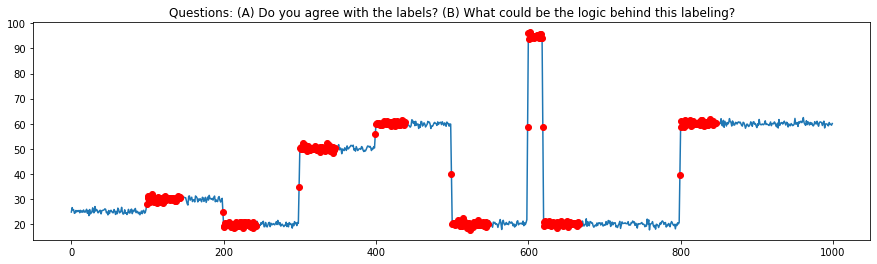

In [4]:
plt.figure(figsize=(15,4))
plt.plot(t,y);
plt.plot(anom_ind,y[anom_ind],'ro')
plt.title('Questions: (A) Do you agree with the labels? (B) What could be the logic behind this labeling?')
plt.show()

### 5. Data augmentation/ Feature engineering
Data augmentation is one of the main tools of data-centric as well as model-centric AI. In case of image applications, it is common to create more data by doing simple operatins on image like rotation, reflection, etc. In our case, we notice that the time series contains a lot of sharp level changes called change points. Therefore, in addition to the value of time series, the information of change in values should also be used to determine the anomaly labels. 

In [5]:
dy=np.zeros(np.shape(y))
for i in range(1,np.size(y)):
    dy[i]=np.abs(y[i]-y[i-1])

gap=df1['value'].rolling(window = 50,min_periods = 1).mean()
g2ap = df1['value'] - gap

In [6]:
g2ap = g2ap.to_numpy();g2ap=g2ap.reshape(np.size(y),1)

### 6. Model-centric AI
We know that, AI = Code + Data. Suppose we trust the human labeler (subject matter expert) and we want to represent his knowledge in a binary classifier network (anomalous or normal). We will keep the data and the labels fixed and only play with the code (i.e., parameters). Lets see what happens.

### 7. Training a binary classifier
Binary classification is one of the simplest ideas in machine learning. The details can be found here. In this tutorial, we will use tensorflow/keras. You can also use other packages like PyTorch for this.  

### (A) Without augmentation

In [7]:
X=y; Y=labels;
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0);

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape = (1,), activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, epochs=500)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
800/800 [==============================] - 0s 127us/sample - loss: 2.2771 - acc: 0.3500
Epoch 2/500
800/800 [==============================] - 0s 19us/sample - loss: 0.7838 - acc: 0.5875
Epoch 3/500
800/800 [==============================] - 0s 18us/sample - loss: 0.7118 - acc: 0.6500
Epoch 4/500
800/800 [==============================] - 0s 19us/sample - loss: 0.6727 - acc: 0.6500
Epoch 5/500
800/800 [==============================] - 0s 17us/sample - loss: 0.6614 - acc: 0.6500
Epoch 6/500
800/800 [==============================] - 0s 17us/sample - loss: 0.6611 - acc: 0.6500
Epoch 7/500
800/800 [==============================] - 0s 19us/sample - loss: 0.6617 - acc: 0.6500
Epoch 8/500
800/800 [==============================] - 0s 17us/sample - loss: 0.6598 - acc: 0.

### (B) With augmentation

In [9]:
X=np.concatenate((y,dy,g2ap),axis = 1); Y=labels;
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0);

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape = (3,), activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, epochs=500)

Epoch 1/500
800/800 [==============================] - 0s 120us/sample - loss: 2.0307 - acc: 0.3500
Epoch 2/500
800/800 [==============================] - 0s 24us/sample - loss: 0.8635 - acc: 0.3812
Epoch 3/500
800/800 [==============================] - 0s 31us/sample - loss: 0.4439 - acc: 0.8712
Epoch 4/500
800/800 [==============================] - 0s 30us/sample - loss: 0.3677 - acc: 0.8675
Epoch 5/500
800/800 [==============================] - 0s 29us/sample - loss: 0.3306 - acc: 0.8938
Epoch 6/500
800/800 [==============================] - 0s 36us/sample - loss: 0.3044 - acc: 0.9025
Epoch 7/500
800/800 [==============================] - 0s 27us/sample - loss: 0.2846 - acc: 0.9087
Epoch 8/500
800/800 [==============================] - 0s 27us/sample - loss: 0.2663 - acc: 0.9187
Epoch 9/500
800/800 [==============================] - 0s 31us/sample - loss: 0.2502 - acc: 0.9250
Epoch 10/500
800/800 [==============================] - 0s 27us/sample - loss: 0.2351 - acc: 0.9225
Epoch 11

In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.0703283315896988
Test accuracy: 0.99


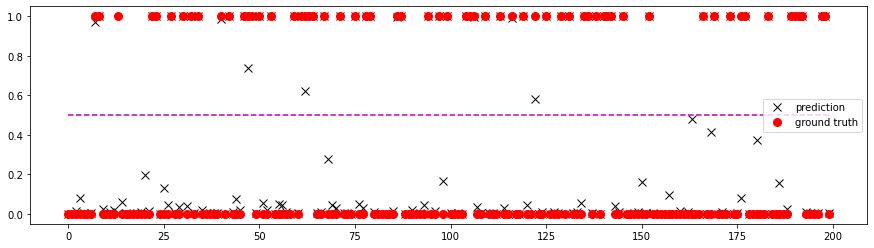

In [11]:
y_pred=model.predict(X_test)
plt.figure(figsize=(15,4))
plt.plot(y_pred,'kx',markersize=8,label ='prediction')
plt.plot(y_test,'ro',markersize=8,label ='ground truth')
plt.plot(0.5*np.ones(np.shape(y_test)),'--m')
plt.legend(loc='center right')
plt.show()


### Results
The classifier doesn't learn the labeling satisfactorily. We suggest you to play with the code parameters (number of layers, number of neurons, activation function, etc) or anything else. We could not get any improvement in our experiments. It would be interesting if you get something :)
### Question
Why our classifier couldn't learn? Please think and share your views.  